# Итоговый проект

### Распакуем файл и посмотрим его структуру

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import gc
import tqdm

In [16]:

# Укажите путь к вашему zip-файлу
zip_file_path = r'C:\Users\Катя\Desktop\diplom\credit\train_data.zip'


In [17]:
# Укажите путь, где вы хотите распаковать файлы
extract_path = r'C:\Users\Катя\Desktop\diplom\credit\extracted_files'


In [18]:
# Создаем папку для распаковки
os.makedirs(extract_path, exist_ok=True)
# Распаковка zip-файла
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Файлы успешно распакованы в {extract_path}")

Файлы успешно распакованы в C:\Users\Катя\Desktop\diplom\credit\extracted_files


## Чтение файлов 0-1

### сокращение объема памяти Pandas DataFrame путем оптимизации типов данных его столбцов

In [19]:
def reduce_mem_usage(df, int_cast=True, obj_to_category=True, subset=None):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    
    :param df: dataframe to reduce (pd.DataFrame)
    :param int_cast: indicate if columns should be tried to be casted to int (bool)
    :param obj_to_category: convert non-datetime related objects to category dtype (bool)
    :param subset: subset of columns to analyse (list)
    :return: dataset with the column dtypes adjusted (pd.DataFrame)
    """
    # Запоминаем начальное использование памяти
    start_mem = df.memory_usage().sum() / 1024 ** 2
    gc.collect()
    print(f'Initial memory usage of dataframe: {start_mem:.2f} MB')

    cols = subset if subset is not None else df.columns.tolist()

   # Функция для изменения типа данных
    def optimize_column(col):
        col_type = col.dtype
        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = col.min()
            c_max = col.max()

            # Оптимизация для целых чисел
            if int_cast and str(col_type).startswith('int'):
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    return col.astype(np.int8)
                elif c_min >= np.iinfo(np.uint8).min and c_max <= np.iinfo(np.uint8).max:
                    return col.astype(np.uint8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    return col.astype(np.int16)
                elif c_min >= np.iinfo(np.uint16).min and c_max <= np.iinfo(np.uint16).max:
                    return col.astype(np.uint16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    return col.astype(np.int32)
                elif c_min >= np.iinfo(np.uint32).min and c_max <= np.iinfo(np.uint32).max:
                    return col.astype(np.uint32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    return col.astype(np.int64)

            # Оптимизация float
            elif str(col_type).startswith('float'):
                if col_type.itemsize == 8:  
                    return col.astype(np.float32)

        # Преобразование типов объектов в категорию
        elif obj_to_category and col_type == object:
            return col.astype('category')

        return col

    # Оптимизируем каждый столбец
    for col in cols:
        df[col] = optimize_column(df[col])

    # Record and print the new memory usage
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print(f'Memory usage after optimization: {end_mem:.2f} MB')
    print(f'Decreased by: {100 * (start_mem - end_mem) / start_mem:.1f}%')

    return df

In [20]:
#Чтение файлов 0-1
path_to_dataset = r'C:\Users\Катя\Desktop\diplom\credit\extracted_files\train_data'
start_from = 0  # Убедитесь, что это целое число

def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.tqdm(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

In [21]:
# Чтение первых 2 файлов (0-1)
data_0_1 = read_parquet_dataset_from_local(path_to_dataset, start_from=0, num_parts_to_read=2, columns=None, verbose=True)
data_0_1.head()


['C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_0.pq', 'C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_1.pq', 'C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_10.pq', 'C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_11.pq', 'C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_2.pq', 'C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_3.pq', 'C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_4.pq', 'C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_5.pq', 'C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_6.pq', 'C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_7.pq', 'C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_8.pq', 'C:\\Us

Reading dataset with pandas:   0%|                                                               | 0/2 [00:00<?, ?it/s]

chunk_path C:\Users\Катя\Desktop\diplom\credit\extracted_files\train_data\train_data_0.pq


Reading dataset with pandas:  50%|███████████████████████████▌                           | 1/2 [00:01<00:01,  1.33s/it]

chunk_path C:\Users\Катя\Desktop\diplom\credit\extracted_files\train_data\train_data_1.pq


Reading dataset with pandas: 100%|███████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.30s/it]


,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0


### Чтение следующих 2-3 файлов 

In [22]:
# Чтение следующих 2-3 файлов 
data_2_3 = read_parquet_dataset_from_local(path_to_dataset, start_from=2, num_parts_to_read=2, verbose=True)
data_2_3.head()

['C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_0.pq', 'C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_1.pq', 'C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_10.pq', 'C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_11.pq', 'C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_2.pq', 'C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_3.pq', 'C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_4.pq', 'C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_5.pq', 'C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_6.pq', 'C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_7.pq', 'C:\\Users\\Катя\\Desktop\\diplom\\credit\\extracted_files\\train_data\\train_data_8.pq', 'C:\\Us

Reading dataset with pandas:   0%|                                                               | 0/2 [00:00<?, ?it/s]

chunk_path C:\Users\Катя\Desktop\diplom\credit\extracted_files\train_data\train_data_10.pq


Reading dataset with pandas:  50%|███████████████████████████▌                           | 1/2 [00:01<00:01,  1.47s/it]

chunk_path C:\Users\Катя\Desktop\diplom\credit\extracted_files\train_data\train_data_11.pq


Reading dataset with pandas: 100%|███████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]


,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,2500000,1,10,3,9,12,13,3,13,2,...,3,3,3,4,1,3,4,1,0,0
1,2500000,2,4,17,16,9,16,12,3,2,...,3,3,3,4,1,3,4,1,0,0
2,2500000,3,3,3,16,15,15,14,14,2,...,3,3,3,4,1,3,3,1,0,0
3,2500000,4,3,3,16,15,15,14,1,2,...,3,3,3,4,1,3,3,1,0,0
4,2500000,5,9,6,6,8,0,11,2,2,...,3,3,3,4,1,2,0,1,0,1


### Создает директорию

In [23]:
def create_directory(path: str):
    """Создает директорию"""
    if not os.path.exists(path):
        os.makedirs(path)

### Обрабатываем данные, создавая новые признаки

In [24]:
def preprocess_transactions(transactions_frame: pd.DataFrame) -> pd.DataFrame:
    """Обрабатывает данные, создавая новые признаки."""
    transactions_frame.fillna(transactions_frame.mean(), inplace=True)
    # Сохраняем id
    transaction_id = transactions_frame['id']  # Сохраняем столбец 'id'

    # Заполнение пропусков средними значениями
    transactions_frame.fillna(transactions_frame.mean(), inplace=True)

    # Преобразование типов данных
    transactions_frame['pre_loans_outstanding'] = transactions_frame['pre_loans_outstanding'].astype('int32')
    transactions_frame['pre_loans_total_overdue'] = transactions_frame['pre_loans_total_overdue'].astype('int32')

    # Создание новых признаков
    #ratio_remaining_to_limit — Отношение оставшейся невыплаченной суммы кредиту к кредитному лимиту. Поможет лучше оценить финансовую нагрузку на заемщика.
    transactions_frame['ratio_remaining_to_limit'] = transactions_frame['pre_loans_next_pay_summ'] / transactions_frame['pre_loans_credit_limit']
    transactions_frame['total_overdue_ratio'] = transactions_frame['pre_loans_next_pay_summ'].where(transactions_frame['pre_loans_next_pay_summ'] > 0).sum() / transactions_frame['pre_loans_credit_limit'].sum() if transactions_frame['pre_loans_credit_limit'].sum() > 0 else 0
    #total_overdue_ratio — отношение текущей просроченной задолженности к общей сумме кредитов. Укажет на уровень задолженности относительно общего долга.
    transactions_frame['total_overdue_ratio'] = transactions_frame['pre_loans_next_pay_summ'].where(transactions_frame['pre_loans_next_pay_summ'] > 0).sum() / transactions_frame['pre_loans_credit_limit'].sum() if transactions_frame['pre_loans_credit_limit'].sum() > 0 else 0
    #max_overdue_significance — бинарный признак, указывающий на то, превышает ли максимальная просроченная задолженность 50% от кредитного лимита. Это важно для оценки кредитного риска.
    transactions_frame['max_overdue_significance'] = (transactions_frame['pre_loans_next_pay_summ'] > 0.5 * transactions_frame['pre_loans_credit_limit']).astype(int)
    #days_since_last_payment — количество дней с последнего выполнения платежа. Указывает на стабильность платежей.
    transactions_frame['days_since_last_payment'] = (pd.Timestamp('today') - pd.to_datetime(transactions_frame['pre_since_confirmed'])).dt.days
    #total_delayed_payments — суммарное количество всех просроченных платежей по всем кредитам, может указывать на кредитную дисциплину заемщика
    transactions_frame['total_delayed_payments'] = transactions_frame[['enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24']].sum(axis=1)
    #average_payment_delay — средний срок задержки платежей за последние N платежей. Это может помочь понять, насколько заемщик склонен задерживать платежи.
    transactions_frame['average_payment_delay'] = transactions_frame[['enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24']].mean(axis=1)
    # Восстанавливаем столбец 'id' обратно в DataFrame
    transactions_frame['id'] = transaction_id
    
    return transactions_frame

### Сохраняем обработанные данные в формате Parquet.

In [25]:
def save_transactions_data(transactions_frame: pd.DataFrame, step: int, save_to_path: str):
    """Сохраняет обработанные данные в формате Parquet."""
    block_as_str = str(step).zfill(2)
    transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))


In [26]:

def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 1, columns=None, verbose=False) -> pd.DataFrame:
    """Читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает."""
    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                            if filename.startswith('train')])
    
    if verbose:
        print(f'Found dataset files: {dataset_paths}')

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]

    if verbose:
        print('Reading chunks:\n', chunks)

    for chunk_path in tqdm.tqdm(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        try:
            # Если columns - это bool, замените его на None
            chunk = pd.read_parquet(chunk_path, columns=columns if isinstance(columns, (list, type(None))) else None)
            res.append(chunk)
        except Exception as e:
            print(f"Error reading {chunk_path}: {e}")

    return pd.concat(res).reset_index(drop=True) if res else pd.DataFrame()  # Предотвращение ошибки при объединении пустого списка

In [27]:
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int = 50,
                                 save_to_path=None, verbose: bool = False):
    """
    Возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи.
    """
    preprocessed_frames = []
    new_feature_frames = []  # Инициализация списка для новых признаков

    # Создание директории для сохранения
    if save_to_path:
        create_directory(save_to_path)

    for step in tqdm.tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once), desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once, verbose)
        
        if transactions_frame.empty:
            print(f'No data loaded for chunk {step}. Skipping...')
            continue
            
        # Препроцессинг данных
        transactions_frame = preprocess_transactions(transactions_frame)

        # Сохранение новых признаков в отдельный DataFrame
        new_features = transactions_frame[['id','ratio_remaining_to_limit', 'total_overdue_ratio', 
                                            'max_overdue_significance', 'days_since_last_payment', 
                                            'total_delayed_payments', 'average_payment_delay']]
        new_feature_frames.append(new_features)

        if verbose:
            print(f"Processed chunk {step}: {transactions_frame.shape[0]} rows.")
            print(transactions_frame.head())  # Печать первых 5 строк обработанных данных

        # Сохранение подготовленных данных в файл
        if save_to_path:
            save_transactions_data(transactions_frame, step // num_parts_to_preprocess_at_once, save_to_path)

    # Объединение новых признаков в один DataFrame
    all_new_features = pd.concat(new_feature_frames, ignore_index=True) if new_feature_frames else pd.DataFrame()

    if all_new_features.empty:
        print("No new features were generated.")
    
    return all_new_features


In [28]:
extract_path = r'C:\Users\Катя\Desktop\diplom\credit\extracted_files\train_data'
data = prepare_transactions_dataset(extract_path, num_parts_to_preprocess_at_once=1, 
                                     num_parts_total=2, save_to_path='traindata/')

Reading dataset with pandas:   0%|                                                               | 0/1 [00:00<?, ?it/s]

chunk_path C:\Users\Катя\Desktop\diplom\credit\extracted_files\train_data\train_data_0.pq



Reading dataset with pandas:   0%|                                                               | 0/1 [00:00<?, ?it/s]

chunk_path C:\Users\Катя\Desktop\diplom\credit\extracted_files\train_data\train_data_1.pq



Transforming transactions data: 100%|████████████████████████████████████████████████████| 2/2 [00:16<00:00,  8.43s/it]


In [29]:
data.head()

,id,ratio_remaining_to_limit,total_overdue_ratio,max_overdue_significance,days_since_last_payment,total_delayed_payments,average_payment_delay
0,0,0.272727,0.246368,0,20042,13,3.25
1,0,inf,0.246368,1,20042,4,1.00
2,0,0.000000,0.246368,0,20042,4,1.00
3,0,0.166667,0.246368,0,20042,13,3.25
4,0,0.200000,0.246368,0,20042,13,3.25


In [30]:
data.shape

(4082029, 7)

In [31]:
data.isnull().sum()  # Проверка на пропуски

id                              0
ratio_remaining_to_limit    43749
total_overdue_ratio             0
max_overdue_significance        0
days_since_last_payment         0
total_delayed_payments          0
average_payment_delay           0
dtype: int64

In [32]:
(data == float('inf')).sum() # Проверка на бесконечные значения

id                               0
ratio_remaining_to_limit    157725
total_overdue_ratio              0
max_overdue_significance         0
days_since_last_payment          0
total_delayed_payments           0
average_payment_delay            0
dtype: int64

In [33]:
# Подсчет среднего значения для столбца
mean_value = data['ratio_remaining_to_limit'].mean()

# Замена NaN значений средним значением без использования 'inplace'
data['ratio_remaining_to_limit'] = data['ratio_remaining_to_limit'].fillna(mean_value)

# Замена бесконечных значений на NaN
data.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

In [34]:
# заполнение пропусков средним значением
mean_value = data['ratio_remaining_to_limit'].mean()
data['ratio_remaining_to_limit'] = data['ratio_remaining_to_limit'].fillna(mean_value)
# Явное приведение типов
data['ratio_remaining_to_limit'] = data['ratio_remaining_to_limit'].infer_objects()

C:\Users\Катя\AppData\Local\Temp\ipykernel_14068\2155341597.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['ratio_remaining_to_limit'] = data['ratio_remaining_to_limit'].fillna(mean_value)


In [35]:
print(data.isnull().sum())
print((data == float('inf')).sum())

id                          0
ratio_remaining_to_limit    0
total_overdue_ratio         0
max_overdue_significance    0
days_since_last_payment     0
total_delayed_payments      0
average_payment_delay       0
dtype: int64
id                          0
ratio_remaining_to_limit    0
total_overdue_ratio         0
max_overdue_significance    0
days_since_last_payment     0
total_delayed_payments      0
average_payment_delay       0
dtype: int64


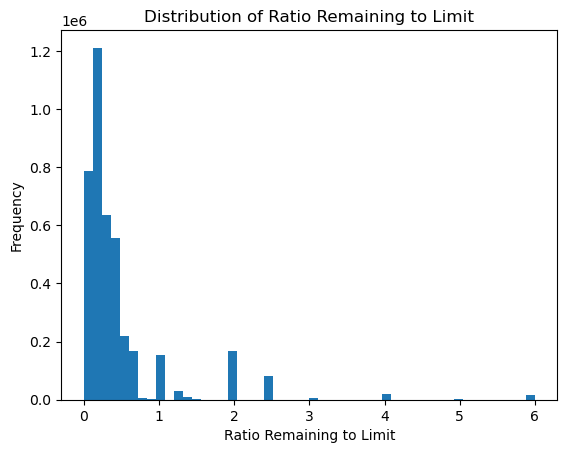

In [36]:
#анализ распределения значений в столбце ratio_remaining_to_limit, чтобы понять, как они распределены.

import matplotlib.pyplot as plt

plt.hist(data['ratio_remaining_to_limit'].dropna(), bins=50)
plt.xlabel('Ratio Remaining to Limit')
plt.ylabel('Frequency')
plt.title('Distribution of Ratio Remaining to Limit')
plt.show()

### Используем функцию prepare_transactions_dataset для считывания всех партиций от 0 до 12

In [37]:
#используем функцию prepare_transactions_dataset для считывания всех партиций от 0 до 12
new_features = prepare_transactions_dataset(path_to_dataset, num_parts_to_preprocess_at_once=2, num_parts_total=12, verbose=True)
new_features

Reading dataset with pandas:   0%|                                                               | 0/2 [00:00<?, ?it/s]

chunk_path C:\Users\Катя\Desktop\diplom\credit\extracted_files\train_data\train_data_0.pq



Reading dataset with pandas:  50%|███████████████████████████▌                           | 1/2 [00:00<00:00,  1.20it/s]

chunk_path C:\Users\Катя\Desktop\diplom\credit\extracted_files\train_data\train_data_1.pq



Transforming transactions data:  17%|████████▋                                           | 1/6 [00:08<00:43,  8.74s/it]

Processed chunk 0: 4082029 rows.
   id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0   0   1                18                    9          2          3   
1   0   2                18                    9         14         14   
2   0   3                18                    9          4          8   
3   0   4                 4                    1          9         12   
4   0   5                 5                   12         15          2   

   pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0               16               10                      11   
1               12               12                       0   
2                1               11                      11   
3               16                7                      12   
4               11               12                      10   

   pre_loans_next_pay_summ  ...  enc_loans_credit_type  enc_loans_account_cur  \
0                        3  ...                      4        


Reading dataset with pandas:   0%|                                                               | 0/2 [00:00<?, ?it/s]

chunk_path C:\Users\Катя\Desktop\diplom\credit\extracted_files\train_data\train_data_10.pq



Reading dataset with pandas:  50%|███████████████████████████▌                           | 1/2 [00:01<00:01,  1.06s/it]

chunk_path C:\Users\Катя\Desktop\diplom\credit\extracted_files\train_data\train_data_11.pq



Transforming transactions data:  33%|█████████████████▎                                  | 2/6 [00:22<00:47, 11.83s/it]

Processed chunk 2: 4747002 rows.
        id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0  2500000   1                10                    3          9         12   
1  2500000   2                 4                   17         16          9   
2  2500000   3                 3                    3         16         15   
3  2500000   4                 3                    3         16         15   
4  2500000   5                 9                    6          6          8   

   pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0               13                3                      13   
1               16               12                       3   
2               15               14                      14   
3               15               14                       1   
4                0               11                       2   

   pre_loans_next_pay_summ  ...  enc_loans_credit_type  enc_loans_account_cur  \
0                        2  ... 


Reading dataset with pandas:   0%|                                                               | 0/2 [00:00<?, ?it/s]

chunk_path C:\Users\Катя\Desktop\diplom\credit\extracted_files\train_data\train_data_2.pq



Reading dataset with pandas:  50%|███████████████████████████▌                           | 1/2 [00:00<00:00,  1.05it/s]

chunk_path C:\Users\Катя\Desktop\diplom\credit\extracted_files\train_data\train_data_3.pq



Transforming transactions data:  50%|██████████████████████████                          | 3/6 [00:32<00:32, 10.70s/it]

Processed chunk 4: 4193100 rows.
       id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0  500000   1                13                    4          8         11   
1  500000   2                13                   14         15          9   
2  500000   3                18                    5         13          2   
3  500000   4                 4                    2          4          8   
4  500000   5                 5                   16          0          8   

   pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0               13                3                      18   
1                3                5                      12   
2                5               10                       6   
3                1               11                      10   
4               14               11                       3   

   pre_loans_next_pay_summ  ...  enc_loans_credit_type  enc_loans_account_cur  \
0                        6  ...       


Reading dataset with pandas:   0%|                                                               | 0/2 [00:00<?, ?it/s]

chunk_path C:\Users\Катя\Desktop\diplom\credit\extracted_files\train_data\train_data_4.pq



Reading dataset with pandas:  50%|███████████████████████████▌                           | 1/2 [00:00<00:00,  1.17it/s]

chunk_path C:\Users\Катя\Desktop\diplom\credit\extracted_files\train_data\train_data_5.pq



Transforming transactions data:  67%|██████████████████████████████████▋                 | 4/6 [00:41<00:20, 10.06s/it]

Processed chunk 6: 4215018 rows.
        id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0  1000000   1                 8                   14         13          2   
1  1000000   2                 8                    0         16         15   
2  1000000   3                14                    2          1          8   
3  1000000   4                10                    6          8          5   
4  1000000   5                17                   16         11          8   

   pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0                9                1                      13   
1                9                1                       5   
2               13               11                       3   
3                6               13                       5   
4                8               11                      14   

   pre_loans_next_pay_summ  ...  enc_loans_credit_type  enc_loans_account_cur  \
0                        2  ... 


Reading dataset with pandas:   0%|                                                               | 0/2 [00:00<?, ?it/s]

chunk_path C:\Users\Катя\Desktop\diplom\credit\extracted_files\train_data\train_data_6.pq



Reading dataset with pandas:  50%|███████████████████████████▌                           | 1/2 [00:00<00:00,  1.07it/s]

chunk_path C:\Users\Катя\Desktop\diplom\credit\extracted_files\train_data\train_data_7.pq



Transforming transactions data:  83%|███████████████████████████████████████████▎        | 5/6 [00:50<00:09,  9.89s/it]

Processed chunk 8: 4398697 rows.
        id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0  1500000   1                16                    5          9         12   
1  1500000   2                16                   11          4          1   
2  1500000   3                16                    1          4          8   
3  1500000   4                16                    9          7          6   
4  1500000   5                16                    7         12         15   

   pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0                4                9                       5   
1                1                7                      13   
2                1               11                      19   
3                4                9                       5   
4                4                9                       1   

   pre_loans_next_pay_summ  ...  enc_loans_credit_type  enc_loans_account_cur  \
0                        2  ... 


Reading dataset with pandas:   0%|                                                               | 0/2 [00:00<?, ?it/s]

chunk_path C:\Users\Катя\Desktop\diplom\credit\extracted_files\train_data\train_data_8.pq



Reading dataset with pandas:  50%|███████████████████████████▌                           | 1/2 [00:00<00:00,  1.02it/s]

chunk_path C:\Users\Катя\Desktop\diplom\credit\extracted_files\train_data\train_data_9.pq



Transforming transactions data: 100%|████████████████████████████████████████████████████| 6/6 [01:00<00:00, 10.05s/it]

Processed chunk 10: 4526871 rows.
        id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0  2000000   1                 8                   13          9         12   
1  2000000   2                15                   13          9         12   
2  2000000   3                14                   13         12         11   
3  2000000   4                14                    4          1          6   
4  2000000   5                10                   14         14         14   

   pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0                9                1                       3   
1                9                1                       3   
2                6               13                      16   
3                3               13                       8   
4               16                5                       0   

   pre_loans_next_pay_summ  ...  enc_loans_credit_type  enc_loans_account_cur  \
0                        2  ...

,id,ratio_remaining_to_limit,total_overdue_ratio,max_overdue_significance,days_since_last_payment,total_delayed_payments,average_payment_delay
0,0,0.272727,0.246473,0,20042,13,3.25
1,0,inf,0.246473,1,20042,4,1.00
2,0,0.000000,0.246473,0,20042,4,1.00
3,0,0.166667,0.246473,0,20042,13,3.25
4,0,0.200000,0.246473,0,20042,13,3.25
...,...,...,...,...,...,...,...
26162712,2499999,0.333333,0.243428,0,20042,13,3.25
26162713,2499999,0.333333,0.243428,0,20042,13,3.25
26162714,2499999,0.428571,0.243428,0,20042,13,3.25
26162715,2499999,0.125000,0.243428,0,20042,13,3.25


In [38]:
new_features.isnull().sum()  # Проверка на пропуски

id                               0
ratio_remaining_to_limit    281728
total_overdue_ratio              0
max_overdue_significance         0
days_since_last_payment          0
total_delayed_payments           0
average_payment_delay            0
dtype: int64

In [39]:
(new_features == float('inf')).sum() # Проверка на бесконечные значения

id                                0
ratio_remaining_to_limit    1127039
total_overdue_ratio               0
max_overdue_significance          0
days_since_last_payment           0
total_delayed_payments            0
average_payment_delay             0
dtype: int64

In [40]:
# Подсчет среднего значения для столбца
mean_value = new_features['ratio_remaining_to_limit'].mean()

# Замена NaN значений средним значением без использования 'inplace'
new_features['ratio_remaining_to_limit'] = new_features['ratio_remaining_to_limit'].fillna(mean_value)

# Замена бесконечных значений на NaN
new_features.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

In [41]:
#заполнение пропусков средним значением
mean_value = new_features['ratio_remaining_to_limit'].mean()
new_features['ratio_remaining_to_limit'] = new_features['ratio_remaining_to_limit'].fillna(mean_value)
# Явное приведение типов
new_features['ratio_remaining_to_limit'] = new_features['ratio_remaining_to_limit'].infer_objects()

C:\Users\Катя\AppData\Local\Temp\ipykernel_14068\1660292029.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_features['ratio_remaining_to_limit'] = new_features['ratio_remaining_to_limit'].fillna(mean_value)


In [42]:
print(data.isnull().sum())
print((data == float('inf')).sum())

id                          0
ratio_remaining_to_limit    0
total_overdue_ratio         0
max_overdue_significance    0
days_since_last_payment     0
total_delayed_payments      0
average_payment_delay       0
dtype: int64
id                          0
ratio_remaining_to_limit    0
total_overdue_ratio         0
max_overdue_significance    0
days_since_last_payment     0
total_delayed_payments      0
average_payment_delay       0
dtype: int64


### Сохраним новые признаки в файл

In [43]:
#сохраним новые признаки в файл
new_features.to_parquet(r'C:\Users\Катя\Desktop\diplom\credit\new_features.parquet')

In [44]:
print(new_features.columns)  # Столбцы в new_features

Index(['id', 'ratio_remaining_to_limit', 'total_overdue_ratio',
       'max_overdue_significance', 'days_since_last_payment',
       'total_delayed_payments', 'average_payment_delay'],
      dtype='object')


In [45]:
# значения целевой переменной (смерджить с фичами по id)
targets = pd.read_csv('train_target.csv')
targets.head()

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [46]:
# Объединяем новые признаки и целевую переменную
merged_data = pd.merge(new_features, targets, on='id', how='inner')

In [47]:
# Проверка результата
merged_data.head()

,id,ratio_remaining_to_limit,total_overdue_ratio,max_overdue_significance,days_since_last_payment,total_delayed_payments,average_payment_delay,flag
0,0,0.272727,0.246473,0,20042,13,3.25,0
1,0,0.457427,0.246473,1,20042,4,1.00,0
2,0,0.000000,0.246473,0,20042,4,1.00,0
3,0,0.166667,0.246473,0,20042,13,3.25,0
4,0,0.200000,0.246473,0,20042,13,3.25,0


In [48]:
merged_data.shape

(26162717, 8)

### Сохраняем объединенные данные

In [49]:
# Сохраняем объединенные данные
merged_data.to_parquet(r'C:\Users\Катя\Desktop\diplom\credit\merged_data.parquet')

In [35]:
# Чтение данных из файла Parquet
merged_data = pd.read_parquet(r'C:\Users\Катя\Desktop\diplom\credit\merged_data.parquet')
merged_data

,id,ratio_remaining_to_limit,total_overdue_ratio,max_overdue_significance,days_since_last_payment,total_delayed_payments,average_payment_delay,flag
0,0,0.272727,0.246473,0,20042,13,3.25,0
1,0,0.457427,0.246473,1,20042,4,1.00,0
2,0,0.000000,0.246473,0,20042,4,1.00,0
3,0,0.166667,0.246473,0,20042,13,3.25,0
4,0,0.200000,0.246473,0,20042,13,3.25,0
...,...,...,...,...,...,...,...,...
26162712,2499999,0.333333,0.243428,0,20042,13,3.25,0
26162713,2499999,0.333333,0.243428,0,20042,13,3.25,0
26162714,2499999,0.428571,0.243428,0,20042,13,3.25,0
26162715,2499999,0.125000,0.243428,0,20042,13,3.25,0


### Проверка баланса классов

In [36]:
# Проверка баланса классов
class_distribution = merged_data['flag'].value_counts()
class_distribution


flag
0    25282908
1      879809
Name: count, dtype: int64

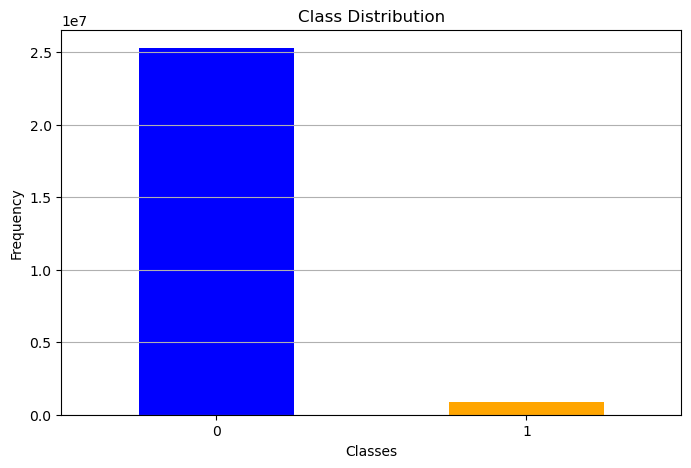

In [37]:
# Визуализация баланса классов
import matplotlib.pyplot as plt

# Визуализация баланса классов
plt.figure(figsize=(8, 5))  # Установка размера фигуры
class_distribution.plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution')  # Заголовок графика
plt.xlabel('Classes')  # Подпись оси X
plt.ylabel('Frequency')  # Подпись оси Y
plt.xticks(rotation=0)  # Поворот меток по оси X для улучшения читаемости
plt.grid(axis='y')  # Добавление сетки по оси Y
plt.show()  # Отображение графика

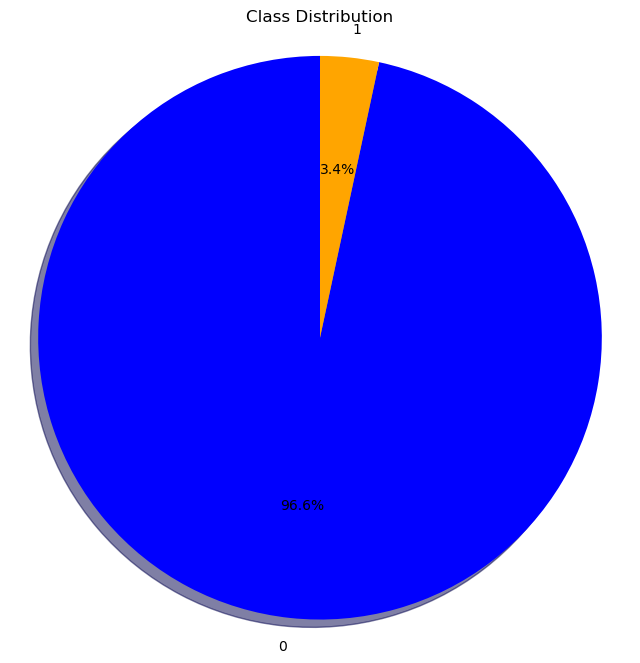

In [38]:
import matplotlib.pyplot as plt

# Предположим, class_distribution это Series, который содержит распределение классов
# Например, class_distribution = merged_data['flag'].value_counts()

# Визуализация баланса классов в виде круговой диаграммы
plt.figure(figsize=(8, 8))  # Установка размера фигуры

# Создание круговой диаграммы
plt.pie(class_distribution, 
        labels=class_distribution.index, 
        autopct='%1.1f%%',  # Формат отображения процентов
        colors=['blue', 'orange'],  # Цвета классов
        startangle=90,  # Начальный угол
        shadow=True)  # Добавление тени

plt.title('Class Distribution')  # Заголовок графика
plt.axis('equal')  # Обеспечение равных осей, чтобы круг выглядел кругом
plt.show()  # Отображение графика

### Анализ дисбаланса классов
 Наличие96.66% одного класса (инийй)и  3.4% другого оранжевыйй) указывает на очень сильный дисбаланс. Это может привести к проблемам при обучении моделей машинного обучения, поскольку алгоритмы могут предпочитать более представительный класс, игнорируя менее представительный.нных.

###  Использование весов классов

In [39]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
import pickle

In [40]:
# Отделение признаков от целевой переменной
X = merged_data.drop('flag', axis=1)  
y = merged_data['flag']  # целевая переменная

In [41]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
# Применение SMOTE для сбалансирования классов
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)  

In [42]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [43]:
# Создание StandardScaler
scaler = StandardScaler()

In [44]:
# Создание модели RandomForestClassifier
model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=30, max_depth=15, n_jobs=-1)

In [45]:
# Создание пайплайна
pipeline = Pipeline(steps=[
    ('scaler', scaler),  # Сначала масштабирование признаков
    ('model', model)     # Затем модель
])
pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        n_estimators=30, n_jobs=-1,
                                        random_state=42))])

In [46]:
# Обучение пайплайна
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        n_estimators=30, n_jobs=-1,
                                        random_state=42))])

In [47]:
# Прогнозы на тестовой выборке
y_pred = pipeline.predict(X_test)

In [48]:
# Расчет метрики ROC-AUC
y_prob = pipeline.predict_proba(X_test)[:, 1]  # предсказания вероятностей для класса 1
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

In [49]:
# Вывод AUC
print(f'AUC: {roc_auc:.2f}')

AUC: 0.79


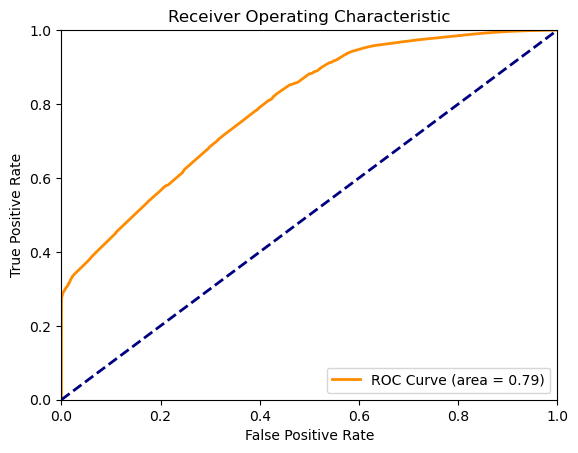

In [50]:
# Построение ROC-кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [51]:
# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.6958
              precision    recall  f1-score   support

           0       0.78      0.54      0.64   5054992
           1       0.65      0.85      0.74   5058172

    accuracy                           0.70  10113164
   macro avg       0.72      0.70      0.69  10113164
weighted avg       0.72      0.70      0.69  10113164



#### Анализ

### при n_estimators=50, max_depth=10
AUC: 0.76

precision    recall  f1-score   support

           0       0.78      0.46      0.58   5054992
           1       0.62      0.87      0.72   5058172

    accuracy                           0.67  10113164
   macro avg       0.70      0.67      0.65  10113164
weighted avg       0.70      0.67      0.65  10113164

Модель имеет высокий Recall для класса 1 (0.87), что означает, что она хорошо справляется с выявлением положительных случаев, но у неё более низкий Recall для класса 0 (0.46). Это может указывать на то, что модель склонна к ошибкам с классом 0, возможно, из-за несбалансированности классов, даже после применения SMOTE.

In [52]:
# Сохранение модели в бинарном формате
with open(r'C:\Users\Катя\Desktop\diplom\credit\model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

In [53]:
# Функция для предсказания
def make_predictions(input_data):
    with open(r'C:\Users\Катя\Desktop\diplom\credit\model.pkl', 'rb') as f:
        loaded_model = pickle.load(f)
    
    predictions = loaded_model.predict(input_data)
    return predictions

In [54]:
# Использование функции для предсказания на тестовом наборе
test_predictions = make_predictions(X_test)
print(test_predictions)

[0 1 0 ... 1 1 1]


### Ансамбли моделей 

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

In [56]:
# Определение базовых моделей
model1 = LogisticRegression(random_state=42)
model2 = RandomForestClassifier(class_weight='balanced', n_estimators=20, max_depth=10, random_state=42, n_jobs=-1)
model3 = GradientBoostingClassifier(random_state=42)

In [57]:
# Создание Voting Classifier
voting_model = VotingClassifier(estimators=[
    ('logreg', model1),
    ('rf', model2),
    ('gb', model3)
], voting='soft')  # "soft" голосование - использует вероятности

In [58]:
# Обучение Voting Classifier
voting_model.fit(X_train, y_train)


VotingClassifier(estimators=[('logreg', LogisticRegression(random_state=42)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=10,
                                                     n_estimators=20, n_jobs=-1,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(random_state=42))],
                 voting='soft')

In [59]:
# Прогнозы на тестовой выборке
y_pred_voting = voting_model.predict(X_test)

In [60]:
# Оценка модели
accuracy_voting = accuracy_score(y_test, y_pred_voting)

In [61]:
print(f"Voting Classifier Accuracy: {accuracy_voting:.4f}")
print(classification_report(y_test, y_pred_voting))

Voting Classifier Accuracy: 0.8039
              precision    recall  f1-score   support

           0       0.81      0.79      0.80   5054992
           1       0.80      0.82      0.81   5058172

    accuracy                           0.80  10113164
   macro avg       0.80      0.80      0.80  10113164
weighted avg       0.80      0.80      0.80  10113164



#### Вывод:
1. Хорошая производительность: Общая точность выше 80% считается хорошим показателем.
2. Баланс между классами: У модели есть баланс между классами. Параметры precision и recall достаточно близки друг к другу, что говорит о низком количестве ложных положительных и ложных отрицательных прогнозов